In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras.layers import Flatten, Dense, Activation
import matplotlib.pyplot as plt
from scipy.integrate import simps
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import visualkeras
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from PIL import Image
import pickle


## extracting_images , Data preprocessing and augmentation

In [ ]:
dataset_dir=r"/home/sunidhi/Desktop/vss/DEEP LEARNING/dataset_brain/Train"
classes=['glioma','meningioma','notumor','pituitary']
input_shape = (224, 224, 3)
num_classes = 4
batch_size = 32
epochs = 50


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb', 
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


## visualization of images

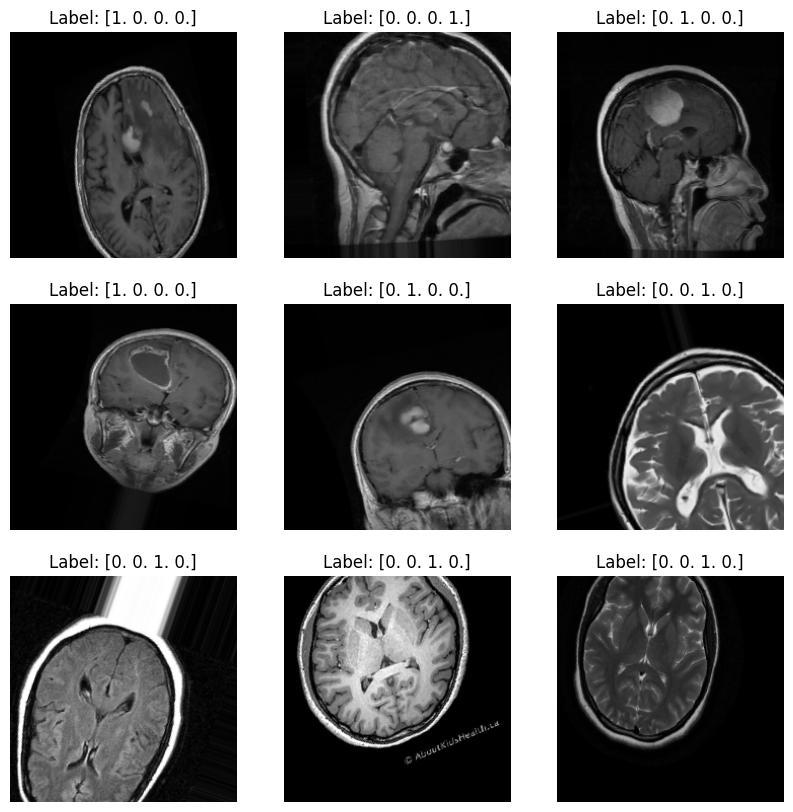

In [13]:
batch = next(train_generator)
images = batch[0] 
labels = batch[1] 

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap='gray') 
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
plt.show()


## model

In [18]:
base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Base input and output
base_input = base_model.input
base_output = base_model.layers[-1].output

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_output)  
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
final_output = Dense(num_classes, activation='softmax')(x)  # Softmax for multi-class classification

# Define the final model
final_model = Model(inputs=base_input, outputs=final_output)

In [21]:
final_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[
        keras.metrics.CategoricalAccuracy(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC()
    ]
)

final_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

## Training

In [22]:

steps_per_epoch = 4571// batch_size
validation_steps =  1141// batch_size

history = final_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    )

Epoch 1/50
142/142 [==============================] - 42s 282ms/step - loss: 6.5316 - categorical_accuracy: 0.8625 - precision_2: 0.8798 - recall_2: 0.8451 - auc_2: 0.9727 - val_loss: 6.2173 - val_categorical_accuracy: 0.8223 - val_precision_2: 0.8499 - val_recall_2: 0.7937 - val_auc_2: 0.9559
Epoch 2/50
142/142 [==============================] - 40s 282ms/step - loss: 5.5889 - categorical_accuracy: 0.9022 - precision_2: 0.9103 - recall_2: 0.8920 - auc_2: 0.9857 - val_loss: 5.3385 - val_categorical_accuracy: 0.8491 - val_precision_2: 0.8679 - val_recall_2: 0.8330 - val_auc_2: 0.9745
Epoch 3/50
142/142 [==============================] - 40s 279ms/step - loss: 4.8333 - categorical_accuracy: 0.9233 - precision_2: 0.9313 - recall_2: 0.9143 - auc_2: 0.9908 - val_loss: 4.6349 - val_categorical_accuracy: 0.8795 - val_precision_2: 0.8950 - val_recall_2: 0.8679 - val_auc_2: 0.9807
Epoch 4/50
142/142 [==============================] - 40s 280ms/step - loss: 4.1919 - categorical_accuracy: 0.9432 

In [ ]:
final_model.save('brain.h5')

## Testing 

In [ ]:

    
model = keras.models.load_model('/home/sunidhi/Desktop/vss/DEEP LEARNING/brain.h5')
compiled_metrics = model.metrics

test_data_generator = ImageDataGenerator(rescale=1.0/255.0)  

test_generator = test_data_generator.flow_from_directory(
    '/home/sunidhi/Desktop/vss/DEEP LEARNING/dataset_brain/Test',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False 
)

result = model.evaluate(test_generator)

print("Test Loss:", result[0])
print("Test Accuracy:", result[1])
print("Test Accuracy:", result[1]*100)

Found 1311 images belonging to 4 classes.
41/41 [==============================] - 2s 44ms/step - loss: 0.1889 - categorical_accuracy: 0.9527 - precision_2: 0.9549 - recall_2: 0.9519 - auc_2: 0.9920
Test Loss: 0.18888644874095917
Test Accuracy: 0.952707827091217
Test Accuracy: 95.2707827091217


 ## Plotting training and validation loss over epochs

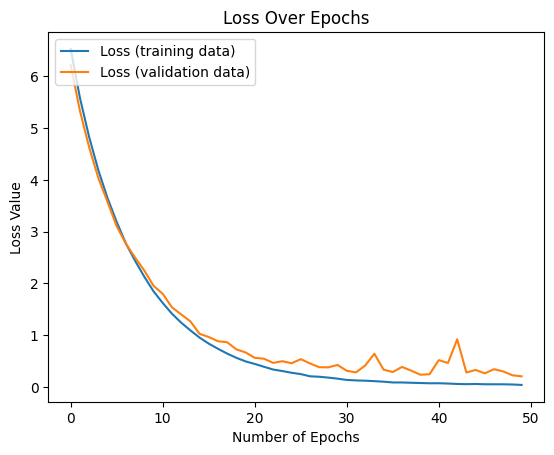

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss Over Epochs')
plt.ylabel('Loss Value')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.savefig('Training-Validation_loss_v1_softplus_100_layer_4_original_data.png')
plt.show()


## accuracy

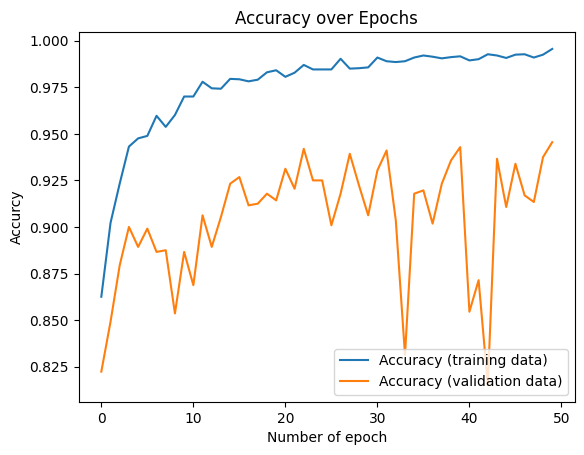

In [29]:
plt.plot(history.history['categorical_accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy over Epochs')
plt.ylabel('Accurcy')
plt.xlabel('Number of epoch')
plt.legend(loc="lower right")
plt.show()


## Confusion Matrix

41/41 [==============================] - 2s 38ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.94      0.94       300
  meningioma       0.97      0.88      0.92       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.90      1.00      0.95       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311


Confusion Matrix:
[[281   8   0  11]
 [  9 268   6  23]
 [  5   0 400   0]
 [  0   0   0 300]]


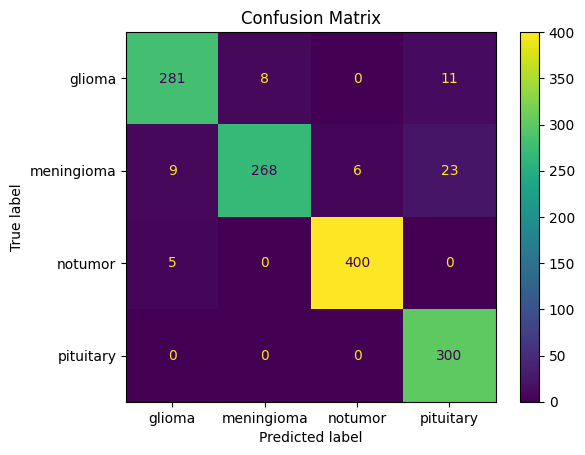

In [31]:
# True labels (class integers) from the generator
y_true = test_generator.classes

# Predicted labels (class integers) from the model
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plotting Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot()
plt.title('Confusion Matrix')
plt.show()


In [32]:
# Detailed Accuracy Metrics
print("\nDetailed Accuracy Metrics:")
report = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()), output_dict=True)
for label, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"Class '{label}' - Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1-Score: {metrics['f1-score']:.2f}")


Detailed Accuracy Metrics:
Class 'glioma' - Precision: 0.95, Recall: 0.94, F1-Score: 0.94
Class 'meningioma' - Precision: 0.97, Recall: 0.88, F1-Score: 0.92
Class 'notumor' - Precision: 0.99, Recall: 0.99, F1-Score: 0.99
Class 'pituitary' - Precision: 0.90, Recall: 1.00, F1-Score: 0.95
Class 'macro avg' - Precision: 0.95, Recall: 0.95, F1-Score: 0.95
Class 'weighted avg' - Precision: 0.95, Recall: 0.95, F1-Score: 0.95


1/1 [==============================] - 0s 237ms/step


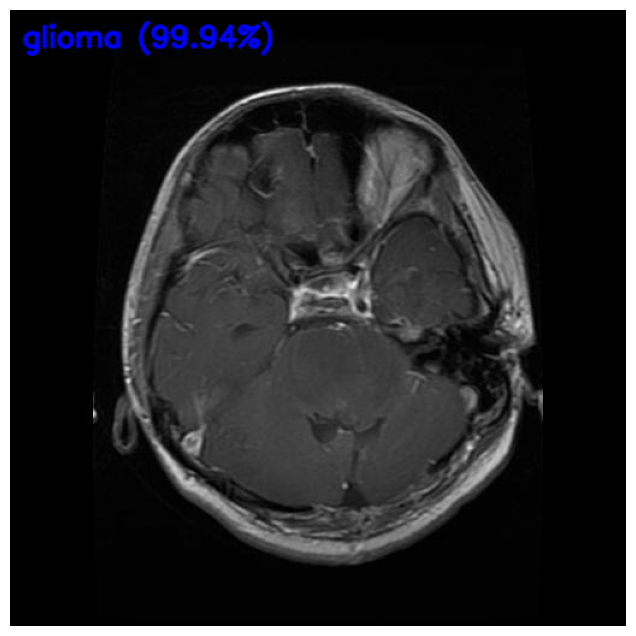

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt

model_path = '/home/sunidhi/Desktop/vss/DEEP LEARNING/brain.h5'
image_path = '/home/sunidhi/Desktop/vss/DEEP LEARNING/dataset_brain/Test/glioma/Te-gl_0010.jpg'  # Replace with your image path
input_shape = (224, 224)
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

model = keras.models.load_model(model_path)

def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, target_size)
    image_normalized = image_resized / 255.0
    image_preprocessed = np.expand_dims(image_normalized, axis=0)
    return image_preprocessed, image_rgb

def predict_and_display(image_path):
    input_image, original_image = preprocess_image(image_path, input_shape)
    prediction = model.predict(input_image)
    predicted_class_index = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class_index]
    predicted_class_name = class_names[predicted_class_index]
    confidence_text = f"{predicted_class_name} ({confidence * 100:.2f}%)"
    color = (0, 255, 0) if predicted_class_index == 2 else (0, 0, 255)
    annotated_image = cv2.putText(original_image.copy(), confidence_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)
    plt.figure(figsize=(8, 8))
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.show()

predict_and_display(image_path)


1/1 [==============================] - 0s 259ms/step


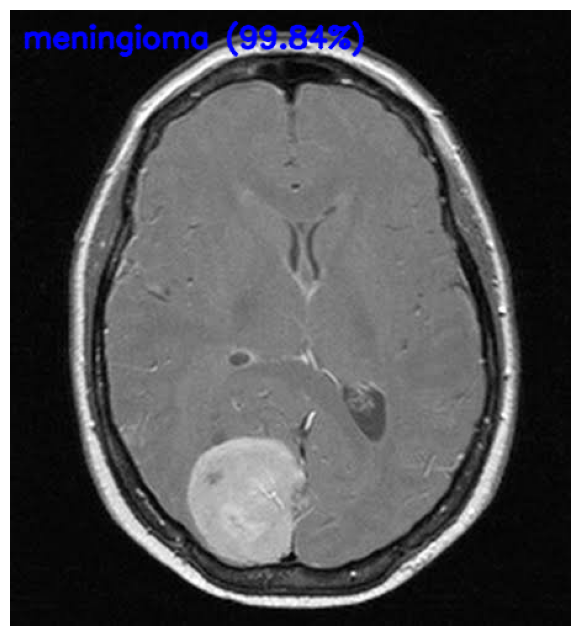

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt

model_path = '/home/sunidhi/Desktop/vss/DEEP LEARNING/brain.h5'
image_path = '/home/sunidhi/Desktop/vss/DEEP LEARNING/dataset_brain/Test/meningioma/Te-me_0010.jpg'  # Replace with your image path
input_shape = (224, 224)
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

model = keras.models.load_model(model_path)

def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, target_size)
    image_normalized = image_resized / 255.0
    image_preprocessed = np.expand_dims(image_normalized, axis=0)
    return image_preprocessed, image_rgb

def predict_and_display(image_path):
    input_image, original_image = preprocess_image(image_path, input_shape)
    prediction = model.predict(input_image)
    predicted_class_index = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class_index]
    predicted_class_name = class_names[predicted_class_index]
    confidence_text = f"{predicted_class_name} ({confidence * 100:.2f}%)"
    color = (0, 255, 0) if predicted_class_index == 2 else (0, 0, 255)
    annotated_image = cv2.putText(original_image.copy(), confidence_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)
    plt.figure(figsize=(8, 8))
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.show()

predict_and_display(image_path)
